In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.misc import derivative

In [2]:
class BVP(object): 
    def __init__(self, f, fk,alpha, b, c, Xk, g0=0, g1=0, l=0, r=1):
        self.f = f                            # right hand side
        self.fk = fk                          # quadrature load element
        self.alpha = alpha                    # diffusion coefficient
        self.b = b                            # convective term/fluid velocity
        self.c = c                            # decay rate
        self.Xk = Xk                          # Nodes, elements K(i) = (x(i-1), x(i))
        self.g0 = g0                          # left boundary condition
        self.g1 = g1                          # right boundary condition
        self.l = l                            # left boundary position 
        self.r = r                            # right boundary position
        self.update_attributes()

    def update_attributes(self):
        self.Mi = len(self.Xk)                     # Number of nodes
        self.T = np.array([self.Xk[:-1], self.Xk[1:]]).T # Set of elements/triangulation
        self.H = self.Xk[1:] - self.Xk[:-1]       # Element sizes
        self.Mk = len(self.Xk) - 1                # Number of elements

    def set_Xk(self, Xk):
        self.Xk = Xk
        self.update_attributes()

- Elemental stiffness matrix and elemental load vector

In [3]:
def stiffness_element(k, bvp):
    '''
    Input:
        k  : Index
        bvp: Boundary value problem [object]
    Output:
        One element in the stiffness matrix
    '''
    
    Ak = np.array([[bvp.alpha*(1/bvp.H[k]) + bvp.c/3 * bvp.H[k], -bvp.alpha/bvp.H[k] + bvp.b/2 + bvp.c/6 * bvp.H[k]], 
                   [-bvp.alpha/bvp.H[k] - bvp.b/2 + bvp.c/6 * bvp.H[k], bvp.alpha*(1/bvp.H[k]) + bvp.c/3 * bvp.H[k]]],
                  dtype=float)
    return Ak

def stiffness_matrix(bvp):
    '''
    Assembles the stiffness matrix A and computes the load vector F
    Input:
        bvp  : Boundary value problem [object]
    '''
    A = np.zeros((bvp.Mi, bvp.Mi), dtype=float)
    F = np.zeros(bvp.Mi)

    for k in range(bvp.Mk):
        A[k:k+2, k:k+2] += stiffness_element(k, bvp)
        F[k:k+2]        += bvp.fk(k,bvp)
    
    
    return A, F

In [4]:
def FEMsolver(bvp):
    '''
    
    '''
    A, F = stiffness_matrix(bvp)
    A[0,:] = 0;
    A[0,0] = 1
    F[0] = 0
    A[-1,:] = 0
    A[-1,-1] = 1
    F[-1] = 0
    
    U = np.linalg.solve(A, F)
    return U    

- Define $f$ and $u$ for the test case $u = x(1-x)$.

In [5]:
def fk_ex1(k, bvp):
    '''
    Quadrature to find RHS. Element within the class BVP
    '''
    X = np.linspace(bvp.T[k,0],bvp.T[k,1],100)
    down = (bvp.T[k,1]-X)/bvp.H[k]
    up = (X-bvp.T[k,0])/bvp.H[k]

    func1 = simps(down*bvp.f(X,bvp),X)
    func2 = simps(up*bvp.f(X,bvp),X)
    
    return np.array([func1,func2])


In [6]:
def u_ex1(x):
    return x*(1-x)
def f_ex1(x,bvp):
    return 2*bvp.alpha + bvp.b*(1-2*x) + bvp.c*x*(1-x)

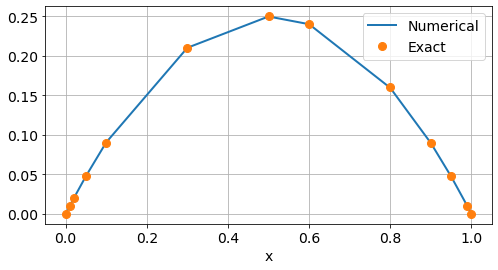

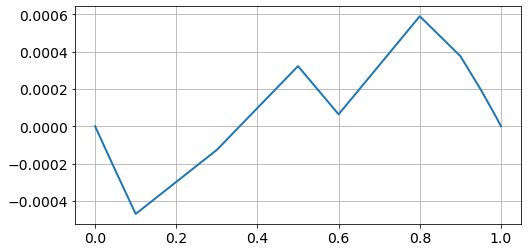

In [7]:
Xk = np.array([0, 0.01,0.02, 0.05, 0.1, 0.3, 0.5, 0.6, 0.8, 0.9,0.95, 0.99, 1])
alpha=10; b=10; c=1;
p1= BVP(f_ex1,fk_ex1, alpha, b, c, Xk)
U = FEMsolver(p1)

plt.plot(Xk,U,Xk,u_ex1(Xk),'o')
plt.legend(['Numerical','Exact'])
plt.xlabel('x')
plt.show()

plt.plot(Xk,u_ex1(Xk)-U)
plt.show()

In [8]:
def convergence(bvp, u_exact,solver=FEMsolver,startPoint=0): 
    P = 7
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    H1conv = np.zeros(P)
    M = 10
    alpha = 1; b = 1; c = 1
    X_samps = np.linspace(startPoint,1,100000)
    for p in range(P):                # Looping over refinement no's: p = 1 , ... P
        Xk_new = np.linspace(startPoint, 1, M)
        bvp.set_Xk(Xk_new)
        U_num = solver(bvp)

        interpolation = interp1d(bvp.Xk,U_num,kind='linear')

        error_L2 = (interpolation(X_samps)-u_exact(X_samps))**2
        
        grad_exact = np.gradient(u_exact(X_samps),X_samps)
        
        grad_num = np.gradient(interpolation(X_samps),X_samps)
        grad_error = (grad_num-grad_exact)**2

        integral = (simps(error_L2,X_samps))**0.5
        integral_grad = (simps(grad_error,X_samps))**0.5

        H1conv[p] = (integral**2 + integral_grad**2)**0.5
        Econv[p] = integral
        Hconv[p] = bvp.H[0]              # Step size
        M = 2*M                          # Doubling no of nodes for refinement no p+1

    order = np.polyfit(np.log10(Hconv),np.log10(Econv),1)[0]       # Linear regression on error values over all refinements
    return Hconv, Econv, order, H1conv

In [9]:
H, E, p,H1 = convergence(p1, u_ex1)

import pandas as pd #To format the output of the notebook.  
RateL2=np.zeros(np.size(E))
RateH1=np.zeros(np.size(E))

RateL2[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
RateH1[1:]=np.log10(H1[1:]/H1[:-1])/np.log10(H[1:]/H[:-1])


pd.options.display.float_format = '{:.8f}'.format
#pd.set_option('display.float_format', '{:.2E}'.format)
df = pd.DataFrame(data={'h': H, 'L2 Error': E ,'L2 Rate':RateL2,'H1 Rate':RateH1}) 
df

,h,L2 Error,L2 Rate,H1 Rate
0,0.11111111,0.00223895,0.00000000,0.00000000
1,0.05263158,0.00050234,2.00008120,1.00095986
2,0.02564103,0.00011923,2.00001860,1.00070036
3,0.01265823,0.00002906,2.00000446,1.00117101
4,0.00628931,0.00000717,2.00000110,1.00230116
5,0.00313480,0.00000178,1.99999977,1.00462037
6,0.00156495,0.00000044,2.00000090,1.00930118


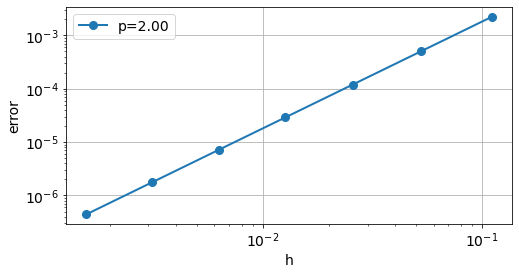

In [10]:
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

In [11]:
def fk_ex3(k,bvp):
    X = np.linspace(bvp.T[k,0],bvp.T[k,1],100)
    
    F_down,F_up = bvp.f(X,bvp,k)
    func1 = simps(F_down,X)
    func2 = simps(F_up,X)
    
    return np.array([func1,func2])

In [12]:
def u_ex3(x): #w3
    return x-x**(3/4)

def f_ex3(x,bvp,k):

    down = (bvp.T[k,1]-x)/bvp.H[k]
    up = (x-bvp.T[k,0])/bvp.H[k]

    F_down = (1-3/4*x**(-1/4))*(-bvp.alpha/bvp.H[k]+bvp.b*down) + bvp.c*(x-x**(3/4))*down
    F_up = (1-3/4*x**(-1/4))*(bvp.alpha/bvp.H[k]+bvp.b*up) + bvp.c*(x-x**(3/4))*up

    return np.array([F_down,F_up])

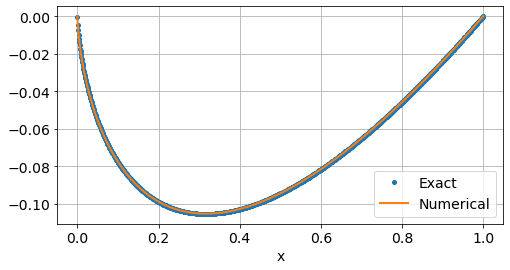

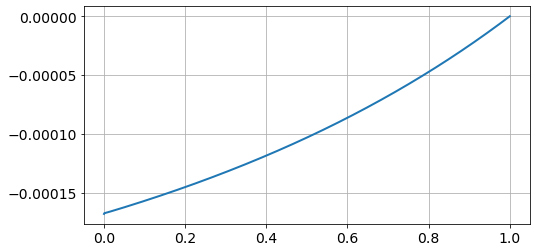

In [13]:
Xk = np.linspace(0.00001,1,1000)
alpha=10; b=10; c=1;
p3 = BVP(f_ex3,fk_ex3, alpha, b, c, Xk)
U = FEMsolver(p3)

plt.plot(Xk, u_ex3(Xk), 'o', markersize=4)
# plt.plot(Xk,U,Xk,u_ex3(Xk),'o', markersize=5)
plt.plot(Xk, U)
plt.legend(['Exact', 'Numerical'])
plt.xlabel('x')
plt.show()

plt.plot(Xk,u_ex3(Xk)-U)
plt.show()


In [37]:
def convergence(bvp, u_exact,solver=FEMsolver,startPoint=0): 
    P = 7
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    H1conv = np.zeros(P)
    M = 10
    alpha = 1; b = 1; c = 1
    X_samps = np.linspace(startPoint,1,100000)
    for p in range(P):                # Looping over refinement no's: p = 1 , ... P
        Xk_new = np.linspace(startPoint, 1, M)
        bvp.set_Xk(Xk_new)
        U_num = solver(bvp)

        interpolation = interp1d(bvp.Xk,U_num,kind='linear')

        error_L2 = (interpolation(X_samps)-u_exact(X_samps))**2
        
        grad_exact = np.gradient(u_exact(X_samps),X_samps)
        
        grad_num = np.gradient(interpolation(X_samps),X_samps)
        grad_error = (grad_num-grad_exact)**2

        integral = (simps(error_L2,X_samps))**0.5
        integral_grad = (simps(grad_error,X_samps))**0.5

        H1conv[p] = (integral**2 + integral_grad**2)**0.5
        Econv[p] = integral
        Hconv[p] = bvp.H[0]              # Step size
        M = 2*M                          # Doubling no of nodes for refinement no p+1

    order = np.polyfit(np.log10(Hconv),np.log10(Econv),1)[0]       # Linear regression on error values over all refinements
    return Hconv, Econv, order, H1conv

In [38]:
H, E, p,H1 = convergence(p3, u_ex3,startPoint=1e-10)

RateL2=np.zeros(np.size(E))
RateH1=np.zeros(np.size(E))

RateL2[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
RateH1[1:]=np.log10(H1[1:]/H1[:-1])/np.log10(H[1:]/H[:-1])


pd.options.display.float_format = '{:.8f}'.format
#pd.set_option('display.float_format', '{:.2E}'.format)
df = pd.DataFrame(data={'h': H, 'L2 Error': E ,'L2 Rate':RateL2,'H1 Rate':RateH1}) 
df

,h,L2 Error,L2 Rate,H1 Rate
0,0.11111111,0.05722957,0.00000000,0.00000000
1,0.05263158,0.02966214,0.87953242,0.39199488
2,0.02564103,0.01500902,0.94729350,0.39096532
3,0.01265823,0.00751412,0.98014087,0.37858843
4,0.00628931,0.00373862,0.99801277,0.36298732
5,0.00313480,0.00185178,1.00902024,0.34912001
6,0.00156495,0.00091361,1.01696393,0.33907557


In [16]:
def u_ex2(x): #w2
    return np.where(x <= 2**0.5/2,2*x/2**0.5,(1-x)/(1-2**0.5/2))

def f_ex2(x,bvp,k):
    index=0
    if k < bvp.Mk-1:
        if bvp.T[k+1,0] < 2**0.5/2 and bvp.T[k+1,1] > 2**0.5/2:
            Xk_new = np.copy(bvp.Xk)
            index = np.argmin(np.abs(Xk_new-np.sqrt(2)/2))
            Xk_new[index] = np.sqrt(2)/2 +1e-14
            bvp.set_Xk(Xk_new)
     

    down = (bvp.T[k,1]-x)/bvp.H[k]
    up = (x-bvp.T[k,0])/bvp.H[k]
    if bvp.T[k,1] <= (2**0.5/2 + 1e-16):
        F_down = (2/2**0.5)*(-bvp.alpha/bvp.H[k]+bvp.b*down) + bvp.c*(2*x/2**0.5)*down
        F_up   = (2/2**0.5)*( bvp.alpha/bvp.H[k]+bvp.b*up)   + bvp.c*(2*x/2**0.5)*up
        return np.array([F_down,F_up])
    else:
        F_down = (-1/(1-2**0.5/2))*(-bvp.alpha/bvp.H[k]+bvp.b*down) + bvp.c*((1-x)/(1-2**0.5/2))*down
        F_up   = (-1/(1-2**0.5/2))*( bvp.alpha/bvp.H[k]+bvp.b*up) +   bvp.c*((1-x)/(1-2**0.5/2))*up

        return np.array([F_down,F_up])

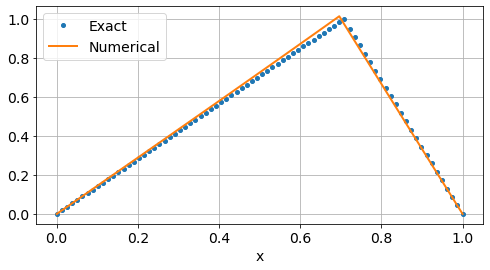

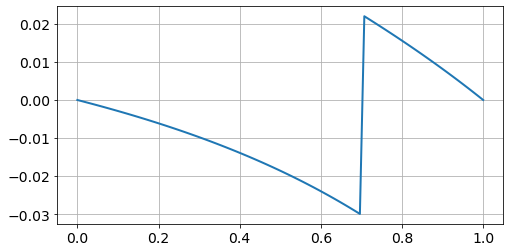

In [17]:
Xk = np.linspace(0,1,80)
alpha=1; b=1; c=1;
p2 = BVP(f_ex2,fk_ex3, alpha, b, c, Xk)
U = FEMsolver(p2)

plt.plot(p2.Xk, u_ex2(p2.Xk), 'o', markersize=4)
plt.plot(p2.Xk, U)
plt.legend(['Exact', 'Numerical'])
plt.xlabel('x')
plt.show()

plt.plot(p2.Xk,u_ex2(p2.Xk)-U)
plt.show()

In [18]:
Xk = np.linspace(0,1,20)
alpha=1; b=1; c=1;
p2 = BVP(f_ex2,fk_ex3, alpha, b, c, Xk)

H, E, p,H1 = convergence(p2, u_ex2)

RateL2=np.zeros(np.size(E))
RateH1=np.zeros(np.size(E))

RateL2[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
RateH1[1:]=np.log10(H1[1:]/H1[:-1])/np.log10(H[1:]/H[:-1])


pd.options.display.float_format = '{:.8f}'.format
#pd.set_option('display.float_format', '{:.2E}'.format)
df = pd.DataFrame(data={'h': H, 'L2 Error': E ,'L2 Rate':RateL2,'H1 Rate':RateH1}) 
df

,h,L2 Error,L2 Rate,H1 Rate
0,0.11111111,0.11762084,0.00000000,0.00000000
1,0.05263158,0.05948449,0.91238952,0.50489980
2,0.02564103,0.01988342,1.52384196,0.51425328
3,0.01265823,0.01472802,0.42518802,0.22655264
4,0.00628931,0.00755753,0.95389378,0.78341432
5,0.00313480,0.00243071,1.62916004,0.84153759
6,0.00156495,0.00180199,0.43081231,0.30231526


In [19]:
def f1(x,bvp):
    return x**(-2/5)

def f2(x,bvp):
    return x**(-7/5)

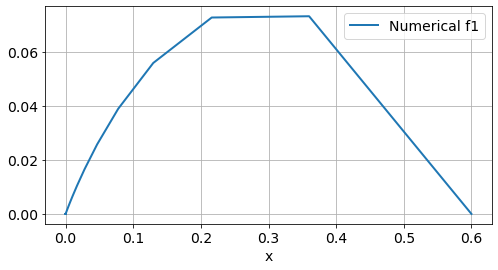

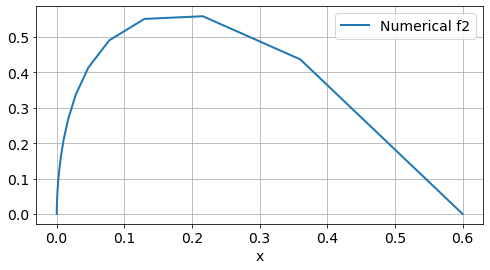

In [20]:
Xk = np.linspace(1e-10,1,80)

alpha=1; b=1; c=1;
r = 0.6

p4 = BVP(f1,fk_ex1, alpha, b, c, Xk)

for i in range(len(Xk)):
    Xk[i] = r**(len(Xk)-i)
p4.set_Xk(Xk)
U = FEMsolver(p4)

plt.plot(p4.Xk, U)
plt.legend(['Numerical f1'])
plt.xlabel('x')
plt.show()

Xk = np.linspace(1e-10,1,80)

alpha=1; b=1; c=1;
p5 = BVP(f2,fk_ex1, alpha, b, c, Xk) #Siden denne ikke er L2, kanskje vi burde lage en egen fk_ex5 for denne?

for i in range(len(Xk)):
    Xk[i] = r**(len(Xk)-i)

p5.set_Xk(Xk)
U = FEMsolver(p5)

plt.plot(p5.Xk, U)
plt.legend(['Numerical f2'])
plt.xlabel('x')
plt.show()

In [32]:
def graded_error(func,fk_func,deg_free):
    alpha=1; b=-100; c=1;
    int_nodes = 5000
    X_samps = np.linspace(1e-10,1,int_nodes)
    bvp = BVP(func,fk_func,alpha,b,c,X_samps)
    u_exact = FEMsolver(bvp)
    r = np.linspace(0.01,0.99,7)
    r[-1] = 1
    L2_error = np.zeros(len(r))
    H1_error = np.zeros(len(r))

    for k in range(len(r)):
        Xk = np.zeros(deg_free)
        for i in range(deg_free):
            Xk[i] = r[k]**(deg_free-i)

        if k == len(r)-1:
            Xk = np.linspace(1e-10,1,10)

        bvp = BVP(func,fk_ex1, alpha, b, c, Xk)
     
        U = FEMsolver(bvp)

        interpolation = interp1d(bvp.Xk,U,kind='linear')
        X_samps = np.linspace(min(bvp.Xk),max(bvp.Xk),int_nodes)
        error_L2 = (interpolation(X_samps)-u_exact)**2
        
        grad_exact = np.gradient(u_exact,X_samps)
        
        grad_num = np.gradient(interpolation(X_samps),X_samps)
        grad_error = (grad_num-grad_exact)**2

        integral = (simps(error_L2,X_samps))**0.5
        integral_grad = (simps(grad_error,X_samps))**0.5
        
        L2_error[k] = integral
        H1_error[k] = (integral**2 + integral_grad**2)**0.5
    return r,L2_error,H1_error

In [35]:
r,L2_error,H1_error = graded_error(f1,fk_ex1,10)
# plt.plot(r,L2_error)
# plt.show()
# plt.plot(r,H1_error)

r_list = r.tolist()
r_list[-1] = "Uniform"
pd.options.display.float_format = '{:.8f}'.format
#pd.set_option('display.float_format', '{:.2E}'.format)
df = pd.DataFrame(data={'r': r_list, 'L2 Error': L2_error ,'H1 error':H1_error}) 
df

,r,L2 Error,H1 error
0,0.01000000,0.00073411,1.11399577
1,0.17333333,0.00189609,0.24249962
2,0.33666667,0.00215939,0.14821881
3,0.50000000,0.00181168,0.09522465
4,0.66333333,0.00153149,0.07422199
5,0.82666667,0.00211028,0.10998763
6,Uniform,0.00327494,0.13188694


In [36]:
r,L2_error,H1_error = graded_error(f2,fk_ex1,10)
r_list = r.tolist()
r_list[-1] = "Uniform"
pd.options.display.float_format = '{:.8f}'.format
#pd.set_option('display.float_format', '{:.2E}'.format)
df = pd.DataFrame(data={'r': r_list, 'L2 Error': L2_error ,'H1 error':H1_error}) 
df

,r,L2 Error,H1 error
0,0.01000000,0.00228382,22.19658089
1,0.17333333,0.02489090,3.86464730
2,0.33666667,0.00862621,2.35608345
3,0.50000000,0.00738688,2.49699836
4,0.66333333,0.01017457,2.67690916
5,0.82666667,0.01759163,2.80951334
6,Uniform,0.02956859,2.41699588


In [24]:
print(max(H1_error),min(H1_error))

22.19658089420155 2.3132255501524313


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ee5611cf-05e8-4382-8cf5-16fd0627b5d6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>